In [93]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns


In [94]:
url = "https://raw.githubusercontent.com/AnjulaMehto/Sampling_Assignment/main/Creditcard_data.csv"
df = pd.read_csv(url)

print(df.shape)
print(df["Class"].value_counts())


(772, 31)
Class
0    763
1      9
Name: count, dtype: int64


In [95]:
fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0]

non_fraud_sampled = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud),
    random_state=42
)

balanced_df = pd.concat([fraud, non_fraud_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42)

print(balanced_df["Class"].value_counts())


Class
1    9
0    9
Name: count, dtype: int64


In [96]:
X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [100]:
def simple_random_sampling(X, y):
    return train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
def bootstrap_sampling(X, y):
    X_bs, y_bs = resample(
        X, y, replace=True, n_samples=len(y), random_state=42
    )
    return train_test_split(
        X_bs, y_bs, test_size=0.3, random_state=42, stratify=y_bs
    )
def cluster_sampling(X, y):
    df_temp = pd.DataFrame(X)
    df_temp["Class"] = y.values

    cluster_indices = np.array_split(df_temp.index, 5)

    selected_indices = np.concatenate(cluster_indices[:3])

    sampled_df = df_temp.loc[selected_indices]

    X_s = sampled_df.drop("Class", axis=1)
    y_s = sampled_df["Class"]

    return train_test_split(
        X_s,
        y_s,
        test_size=0.3,
        random_state=42,
        stratify=y_s
    )

def stratified_sampling(X, y):
    return train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
def systematic_sampling(X, y):
    df_temp = pd.DataFrame(X)
    df_temp["Class"] = y.values

    step = 2
    systematic_sample = df_temp.iloc[::step]

    X_s = systematic_sample.drop("Class", axis=1)
    y_s = systematic_sample["Class"]

    return train_test_split(
        X_s, y_s, test_size=0.3, random_state=42, stratify=y_s
    )


In [101]:
models = {
    "M1_LogisticRegression": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(),
    "M3_RandomForest": RandomForestClassifier(n_estimators=100),
    "M4_SVM": SVC(),
    "M5_NaiveBayes": GaussianNB()
}
sampling_methods = {
    "SimpleRandom": simple_random_sampling,
    "Bootstrap": bootstrap_sampling,
    "Cluster": cluster_sampling,
    "Stratified": stratified_sampling,
    "Systematic": systematic_sampling
}


In [102]:
results = pd.DataFrame(index=models.keys(), columns=sampling_methods.keys())

for s_name, sampler in sampling_methods.items():
    X_train, X_test, y_train, y_test = sampler(X_scaled, y)

    for m_name, model in models.items():

        # Safety check
        if y_train.nunique() < 2:
            results.loc[m_name, s_name] = None
            continue

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred) * 100
        results.loc[m_name, s_name] = round(acc, 2)


In [103]:
print("\nAccuracy Table (%)")
print(results)

results.to_csv("accuracy_table.csv")



Accuracy Table (%)
                      SimpleRandom Bootstrap Cluster Stratified Systematic
M1_LogisticRegression        16.67     100.0    50.0      16.67      66.67
M2_DecisionTree              83.33     100.0   100.0      83.33      66.67
M3_RandomForest              66.67     100.0    75.0       50.0      33.33
M4_SVM                       16.67     100.0     0.0      16.67        0.0
M5_NaiveBayes                66.67     100.0    50.0      66.67      33.33


In [104]:
best_sampling = results.idxmax(axis=1)
best_accuracy = results.max(axis=1)

best_df = pd.DataFrame({
    "Best Sampling Technique": best_sampling,
    "Best Accuracy (%)": best_accuracy
})

print("\nBest Sampling Technique for Each Model")
print(best_df)



Best Sampling Technique for Each Model
                      Best Sampling Technique Best Accuracy (%)
M1_LogisticRegression               Bootstrap             100.0
M2_DecisionTree                     Bootstrap             100.0
M3_RandomForest                     Bootstrap             100.0
M4_SVM                              Bootstrap             100.0
M5_NaiveBayes                       Bootstrap             100.0


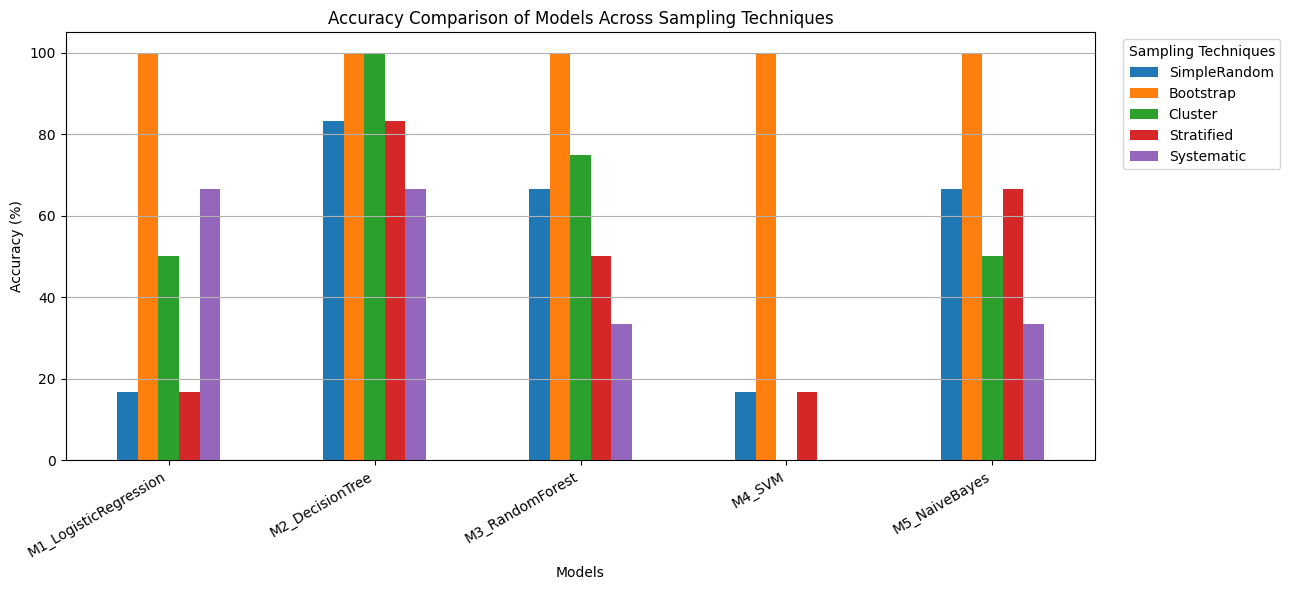

In [105]:
results.astype(float).plot(kind="bar", figsize=(13,6))

plt.title("Accuracy Comparison of Models Across Sampling Techniques")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")

plt.legend(
    title="Sampling Techniques",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()
